In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report,confusion_matrix
%matplotlib inline
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM,Bidirectional,SpatialDropout1D
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Embedding,Flatten,Dense,Dropout
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy import asarray,zeros
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Kaggle/News-Category/dataset/News_Category_Dataset_v2.json', lines=True)
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [9]:
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [11]:
data.isna().apply(pd.value_counts) #missing value check

,category,headline,authors,link,short_description,date
False,200853,200853,200853,200853,200853,200853


In [12]:
data.category.nunique() # number of unique categories

41

In [13]:
data.category.unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

* WORLDPOST and THE WORLDPOST were given as two separate categories in the dataset. Here I change the category THE WORLDPOST to WORLDPOST 

In [14]:
data.category = data.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [15]:
data.category.nunique() # number of unique categories

40

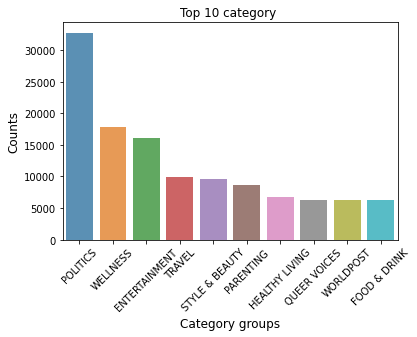

In [16]:
# Plotting top 10 category
group_count = data['category'].value_counts()
sns.barplot(group_count.index[:10], group_count.values[:10], alpha=0.8)
plt.title('Top 10 category ')
plt.ylabel('Counts', fontsize=12)
plt.xlabel('Category groups', fontsize=12,)
plt.xticks(rotation=45)
plt.show()

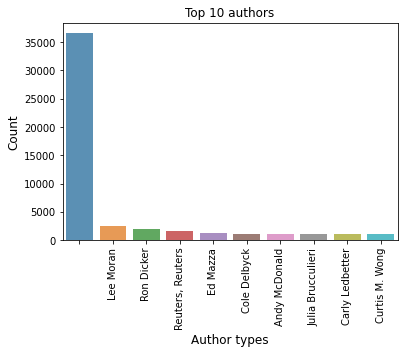

In [17]:
# Plotting top 10 authors
group_count = data['authors'].value_counts()
sns.barplot(group_count.index[:10], group_count.values[:10], alpha=0.8)
plt.title('Top 10 authors')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Author types', fontsize=12,)
plt.xticks(rotation='vertical')
plt.show()

Text(0.5, 1.0, 'Word cloud for Headline column')

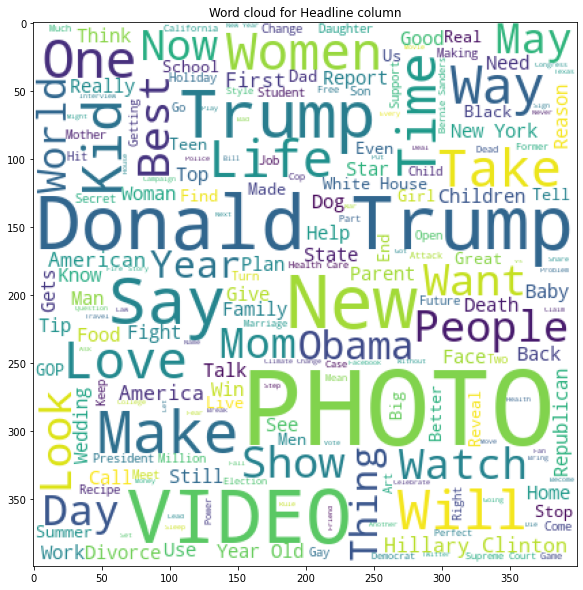

In [18]:
#Plotting word cloud
from wordcloud import WordCloud
desc = " ".join(str(des) for des in data['headline'])

wc_desc = WordCloud(background_color='white', max_words=200, width=400, height=400,random_state=10).generate(desc)
plt.figure(figsize=(10,10))
plt.imshow(wc_desc)
plt.title("Word cloud for Headline column")

Text(0.5, 1.0, 'Word cloud for short description column')

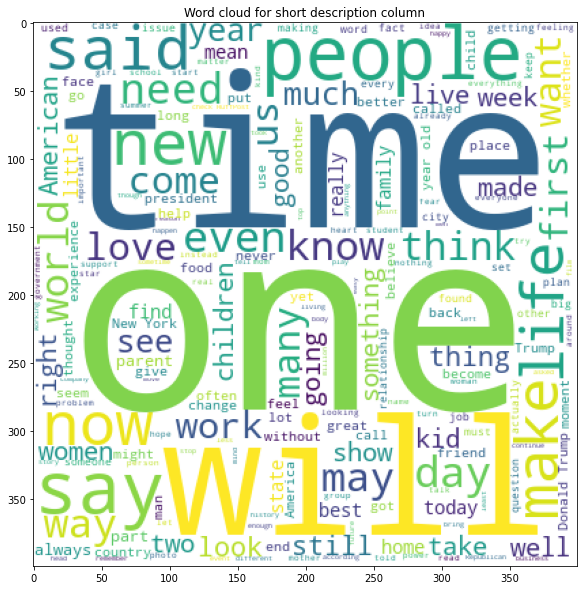

In [19]:
#Plotting word cloud for short description
from wordcloud import WordCloud
desc = " ".join(str(des) for des in data['short_description'])

wc_desc = WordCloud(background_color='white', max_words=200, width=400, height=400,random_state=10).generate(desc)
plt.figure(figsize=(10,10))
plt.imshow(wc_desc)
plt.title("Word cloud for short description column")

### Data cleaning 

In [21]:
import unicodedata
import nltk
nltk.download('stopwords')
import spacy
from nltk.tokenize.toktok import ToktokTokenizer
stopword_list = nltk.corpus.stopwords.words('english')
tokenizer = ToktokTokenizer()
nlp = spacy.load('en_core_web_sm', parse = False, tag=False, entity=False)
#from contractions import CONTRACTION_MAP
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())
stopword_list = nltk.corpus.stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [22]:
import re

#### Defining all functions for data cleaning

In [23]:
# Remove any emails 
def remove_emails(text):
    text = re.sub(r'\b[^\s]+@[^\s]+[.][^\s]+\b', ' ', text)
    return text

def remove_hyperlink(text):
    text=re.sub(r'(http|https)://[^\s]*',' ',text)
    return text

# Removing Digits
def remove_digits(text):
    #text= re.sub(r"\b\d+\b", "", text)
    text= re.sub(r"(\s\d+)", " ", text)
    return text
    

# Removing Special Characters
def remove_special_characters(text):
    text = re.sub('[^a-zA-Z\s]', ' ', text)
    return text


# removing accented charactors
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

 # Removing Stopwords
def remove_stopwords(text,is_lower_case):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]

    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)   
    return filtered_text

# Lemmetization
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [24]:
# Combine all the functions and creating a preprocessing pipeline
# # Text preprocessing
def text_preprocessing(corpus,isRemoveEmail,isRemoveDigits,isRemoveHyperLink, 
                     isRemoveSpecialCharac,isRemoveAccentChar,
                       text_lower_case,text_lemmatization, stopword_removal):
    
    normalized_corpus = []
    
    for doc in corpus:
        
        if text_lower_case:
            doc = doc.lower()
        
        if isRemoveEmail:
            doc = remove_emails(doc)
        
        if isRemoveHyperLink:
            doc=remove_hyperlink(doc)
             
        if isRemoveAccentChar:
            doc = remove_accented_chars(doc)
            
        if isRemoveDigits:
            doc = remove_digits(doc)
        
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        
        if text_lemmatization:
            doc = lemmatize_text(doc)
        
        if isRemoveSpecialCharac:
            doc = remove_special_characters(doc)
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        
        if stopword_removal:
            doc = remove_stopwords(doc,is_lower_case=text_lower_case)
                
        normalized_corpus.append(doc)
        
    return normalized_corpus


In [25]:
EMAIL_FLAG=True
DIGIT_FLAG=True
HYPER_LINK_FLAG=True
ALL_SPEC_CHAR_FLAG=True
ACCENT_CHAR_FLAG=True
LOWER_CASE_FLAG=True
LEMMETIZE_FLAG=False
STOPWORD_FLAG=True

clean_headline= text_preprocessing(data['headline'],EMAIL_FLAG,DIGIT_FLAG,HYPER_LINK_FLAG,
                   ALL_SPEC_CHAR_FLAG,ACCENT_CHAR_FLAG,
                  LOWER_CASE_FLAG,LEMMETIZE_FLAG,STOPWORD_FLAG)
clean_short_Desc = text_preprocessing(data['short_description'],EMAIL_FLAG,DIGIT_FLAG,HYPER_LINK_FLAG,
                   ALL_SPEC_CHAR_FLAG,ACCENT_CHAR_FLAG,
                  LOWER_CASE_FLAG,LEMMETIZE_FLAG,STOPWORD_FLAG)

In [26]:
data['clean_headline']=clean_headline
data['clean_short_Desc'] = clean_short_Desc

### Wordcloud after cleaning the data

### Category wise word cloud

In [27]:
#Description
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))

for index, i in enumerate(data['category'].unique()):
  s = str(i)
  i = str(data[data['category']==s].Merged_data)
  i = WordCloud(background_color='white', max_words=200, width=400, height=400,random_state=10).generate(i)
  c = index+1
  plt.subplot(10,5,c)
  plt.imshow(i)
  plt.title(s)


AttributeError: ignored

<Figure size 1080x1080 with 0 Axes>

* Merging the columns into one

In [28]:
data['MergedColumn'] = data[data.columns[6:8]].apply(
    lambda x: ' '.join(x.astype(str)),
    axis=1
)

In [29]:
pd.set_option('display.max_colwidth', -1)

In [30]:
data['MergedColumn'][0:10]

0    mass shootings texas last week tv left husband killed children another day america                                                                                 
1    smith joins diplo nicky jam world cup official song course song                                                                                                    
2    hugh grant marries first time age actor longtime girlfriend anna eberstein tied knot civil ceremony                                                                
3    jim carrey blasts castrato adam schiff democrats new artwork actor gives dems ass kicking fighting hard enough donald trump                                        
4    julianna margulies uses donald trump poop bags pick dog dietland actress said using bags really cathartic therapeutic moment                                       
5    morgan freeman devastated sexual harassment claims could undermine legacy right equate horrific incidents sexual assault misplaced compliments humor s

#### Creating the final data

In [31]:
final_df = data.copy()
del data
final_df.drop(columns=['headline', 'authors', 'link', 'short_description', 'date',
                   'clean_headline', 'clean_short_Desc'],axis=1,inplace=True)

In [32]:
final_df.columns

Index(['category', 'MergedColumn'], dtype='object')

In [33]:
final_df.to_csv('final_data.csv',index=False)

Text(0.5, 1.0, 'Word cloud for final data after cleaning')

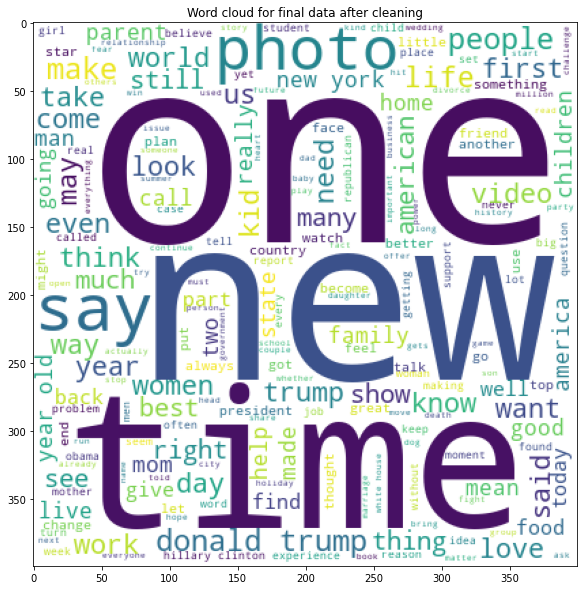

In [34]:
#Plotting word cloud
from wordcloud import WordCloud
desc = " ".join(str(des) for des in final_df['MergedColumn'])

wc_desc = WordCloud(background_color='white', max_words=200, width=400, height=400,random_state=10).generate(desc)
plt.figure(figsize=(10,10))
plt.imshow(wc_desc)
plt.title("Word cloud for final data after cleaning")

#### ML Algorithms

In [35]:
### Count Vectorizer
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(final_df['MergedColumn']).toarray()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X,final_df['category'], test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
del final_df



(160682, 2500)
(160682,)
(40171, 2500)
(40171,)


### Naive Bayes


In [36]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train,y_train)

predictions = nb.predict(X_test)

print('Training accuracy',nb.score(X_train,y_train))

from sklearn.metrics import accuracy_score
print("Testing accuracy " ,accuracy_score(predictions,y_test))

Training accuracy 0.5612078515328413
Testing accuracy  0.5182096537303029


In [37]:
confusion_matrix(y_test,predictions)

array([[ 60,  15,   7, ...,   6,   0,   9],
       [ 24,  46,   8, ...,  19,   2,   3],
       [  4,  10, 255, ...,  12,   1,  13],
       ...,
       [  2,   4,   8, ..., 244,   0,   2],
       [  0,   0,   4, ...,   2,  82, 156],
       [  3,   3,  10, ...,   9,  88, 642]])

In [38]:
classification_report(y_test,predictions)

'                precision    recall  f1-score   support\n\n          ARTS       0.21      0.20      0.20       298\nARTS & CULTURE       0.26      0.16      0.20       283\n  BLACK VOICES       0.39      0.29      0.33       882\n      BUSINESS       0.42      0.41      0.41      1121\n       COLLEGE       0.33      0.27      0.29       243\n        COMEDY       0.45      0.38      0.41      1068\n         CRIME       0.38      0.65      0.48       650\nCULTURE & ARTS       0.29      0.18      0.23       222\n       DIVORCE       0.63      0.65      0.64       696\n     EDUCATION       0.31      0.48      0.37       188\n ENTERTAINMENT       0.54      0.58      0.56      3139\n   ENVIRONMENT       0.39      0.26      0.31       275\n         FIFTY       0.14      0.14      0.14       269\n  FOOD & DRINK       0.52      0.66      0.58      1265\n     GOOD NEWS       0.25      0.21      0.22       276\n         GREEN       0.32      0.31      0.32       515\nHEALTHY LIVING       0.24   

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)
print("Training accuracy",lr.score(X_train,y_train))

predictions = lr.predict(X_test)

from sklearn.metrics import accuracy_score
print("Testing accuracy",accuracy_score(predictions,y_test))

### K Nearest Neighbours


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5,weights='distance')
knn.fit(X_train,y_train)
print("Training accuracy",knn.score(X_train,y_train))

predictions = knn.predict(X_test)

from sklearn.metrics import accuracy_score
print("Testing accuracy",accuracy_score(predictions,y_test))

### SVM

In [ ]:
from sklearn.svm import SVC
svc= SVC(C=1.0,kernel='linear',degree=3,gamma='auto')
svc.fit(X_train,y_train)

print("Training accuracy",svc.score(X_train,y_train))

predictions = svc.predict(X_test)

from sklearn.metrics import accuracy_score
print("Testing accuracy",accuracy_score(predictions,y_test))

### Deep Learning Models

In [ ]:
import matplotlib.pyplot as plt

text_length = []

for text in range(len(final_df['MergedColumn'])):
    try:
        text_length.append(len(final_df['MergedColumn'][text]))

    except Exception as e:
        pass

print("Maximum length of  Data", np.max(text_length))
print("Minimum length of  Data", np.min(text_length))
print("Median length of  Data", np.median(text_length))
print("Average length of  Data",np.mean(text_length))
print("Standard Deviation of  Data",np.std(text_length))
plt.boxplot(text_length)
plt.show()

In [ ]:
# Setting the maximum length of the sentence as 200

In [ ]:
max_features = 2000
maxlen = 200
embedding_size = 200
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(final_df['MergedColumn'])
X = tokenizer.texts_to_sequences(final_df['MergedColumn'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(final_df['category'])
y = pd.get_dummies(final_df['category']).values


In [ ]:
print(X.shape)
print(y.shape)


In [ ]:
del final_df

### Train test split

In [ ]:

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Extract the GloVe embedding file

In [ ]:
embeddings_dictionary = dict()

#glove_file = open('/content/drive/My Drive/glove.6B.200d.txt', encoding="utf8")
glove_file = open('/kaggle/input/glove200dtxt/glove.6B.200d.txt', encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()
num_words = len(tokenizer.word_index) + 1
embedding_matrix = zeros((num_words, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


print(len(embeddings_dictionary.values()))
print("Num words",num_words)
print("matrix size ",embedding_matrix.shape)
print("embeddings size ",embedding_size)
print("Max len",maxlen)

### Building the model

In [ ]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
model.add(SpatialDropout1D(0.2))
#model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(40, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
history= model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64)

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();